In [2]:
import numpy as np
import time 
import os  
import xarray as xr
import subprocess 
import pickle 
from datetime import datetime
# datetime object containing current date and time

now = datetime.now()
print("now =", now)
# dd/mm/YY H:M:S
t_string = now.strftime("%y%m%d%H%M") 

file_path1 = '/scratch/gpfs/cw55/AM4/work/CTL2000_sst0.5Kperyear_nn_stellarcpu_intelmpi_22_768PE/'
file_path2 = '/scratch/gpfs/cw55/AM4/work/CTL2000_sst0.5Kperyear_nn_stellarcpu_intelmpi_22_768PE_base/'
year_list = np.arange(1965,1977)

nn_ratio = np.zeros((2,7,len(year_list)*12))

for yi, year in enumerate(year_list):
    for fi, fp in enumerate([file_path1, file_path2]):
        print(year)
        for ti in range(1,7):
            now = datetime.now()
            print("now =", now)
            ds = xr.open_dataset(fp+f'/HISTORY/{year}0101.atmos_8xdaily.tile{ti}.nc')    
            data = ds['nn_lwup_sfc'].load()
            for mi in range(12):
                time_sel = data.time.dt.month.isin([mi+1])
                tmp = data.isel(time=time_sel).values
                tmp = np.where(tmp<0, 1, 0 )
                tmp_count = np.sum(tmp)
                # print(tmp, data.size, f'{tmp/data.size*100:5.2f}%')
                nn_ratio[fi,ti-1,yi*12+mi] = tmp_count/tmp.size*100
        ds = xr.open_dataset(fp+f'/POSTP/{year}0101.atmos_8xdaily.nc')  
        data = ds['nn_lwup_sfc'].load()
        for mi in range(12):
            time_sel = data.time.dt.month.isin([mi+1])
            tmp = data.isel(time=time_sel).values
            tmp = np.where(tmp<0, 1, 0 )
            tmp_count = np.sum(tmp)
            # print(tmp, data.size, f'{tmp/data.size*100:5.2f}%')
            nn_ratio[fi,6,yi*12+mi] = tmp_count/tmp.size*100 
        
now = datetime.now()
print("now =", now) 

pickle.dump( [year_list,nn_ratio], open( f"nn_ratio.p0.5kpy.{t_string}.p", "wb" ) )



now = 2023-06-09 10:58:27.728099
1965
now = 2023-06-09 10:58:27.728521
now = 2023-06-09 10:58:34.838043
now = 2023-06-09 10:58:41.586045
now = 2023-06-09 10:58:50.093286
now = 2023-06-09 10:58:56.766463
now = 2023-06-09 10:59:03.869873
1965
now = 2023-06-09 10:59:19.948561
now = 2023-06-09 10:59:26.942186
now = 2023-06-09 10:59:34.114902
now = 2023-06-09 10:59:41.350576
now = 2023-06-09 10:59:49.603712
now = 2023-06-09 10:59:56.958015
1966
now = 2023-06-09 11:00:12.763289
now = 2023-06-09 11:00:19.402750
now = 2023-06-09 11:00:26.139999
now = 2023-06-09 11:00:32.647494
now = 2023-06-09 11:00:39.421016
now = 2023-06-09 11:00:46.298208
1966
now = 2023-06-09 11:01:04.718620
now = 2023-06-09 11:01:11.485168
now = 2023-06-09 11:01:17.998680
now = 2023-06-09 11:01:24.558854
now = 2023-06-09 11:01:31.398171
now = 2023-06-09 11:01:38.172982
1967
now = 2023-06-09 11:01:53.593460
now = 2023-06-09 11:02:00.713515
now = 2023-06-09 11:02:07.566455
now = 2023-06-09 11:02:15.906153
now = 2023-06-09 1

# Load results and plot

In [36]:
import numpy as np 
import xarray as xr
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
path.insert(1, '/tigress/cw55/local/python_lib')
from cg_funcs import global_mean_xarray 

In [37]:
plt.rcParams['font.size'] = '6'

In [38]:
year_list, nn_ratio = pickle.load(open("nn_ratio.p0.5kpy.2306091058.p","rb"))
 
tile_name = ['Atlantic', 'Indian','Arctic', 'Pacific', 'America', 'Antarctic']

In [39]:
file_path = '/scratch/gpfs/cw55/AM4/work/CTL2000_sst0.5Kperyear_nn_stellarcpu_intelmpi_22_768PE/'
file_list = [file_path+f'/POSTP/{year}0101.atmos_month.nc' for year in year_list]
ds = xr.open_mfdataset(file_list)
ds = ds.rename({'grid_yt':'lat','grid_xt':'lon'})
ts = ds.t_surf
ts_gm_year = global_mean_xarray(ts.groupby('time.year').mean('time'))
ts_gm_mean = global_mean_xarray(ts.mean('time')).compute()
ts_anom = ts.groupby('time.month') - ts.groupby('time.month').mean('time')
gmst_anom = global_mean_xarray(ts_anom).compute()

/home/cw55/.conda/envs/cg310/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


In [40]:
nino34 = ts_anom.sel(time=slice(str(year_list[0]),str(year_list[-1])))\
.sel(lon = slice(190,240)).sel(lat = slice(-5,5)).mean(['lat','lon']).rolling(time=12,center=True).mean() 

In [41]:
gmst_anom_y = gmst_anom.groupby('time.year').mean()
ytime = gmst_anom.time[::12].data
mtime = gmst_anom.time.data

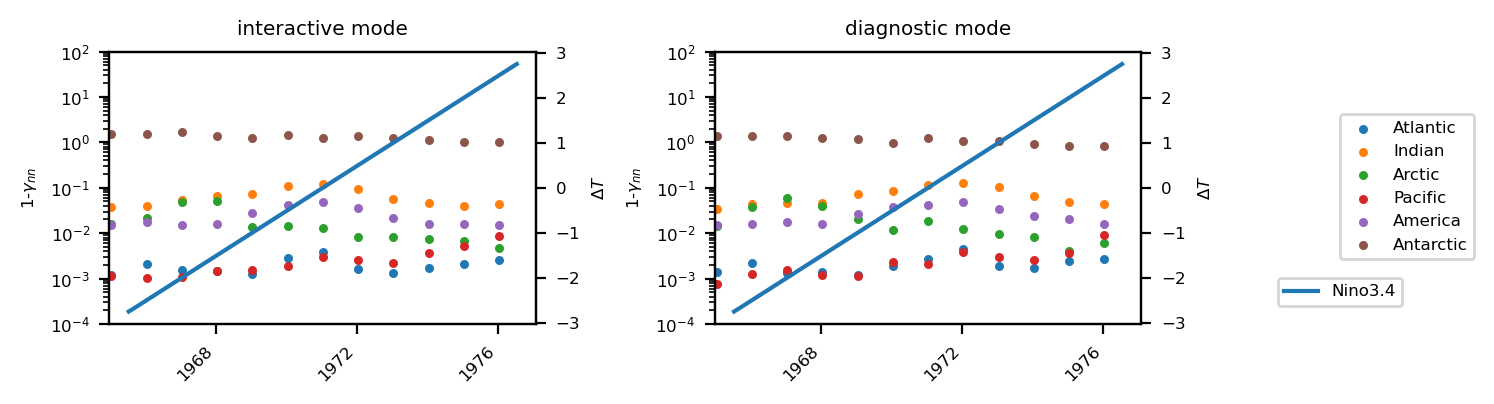

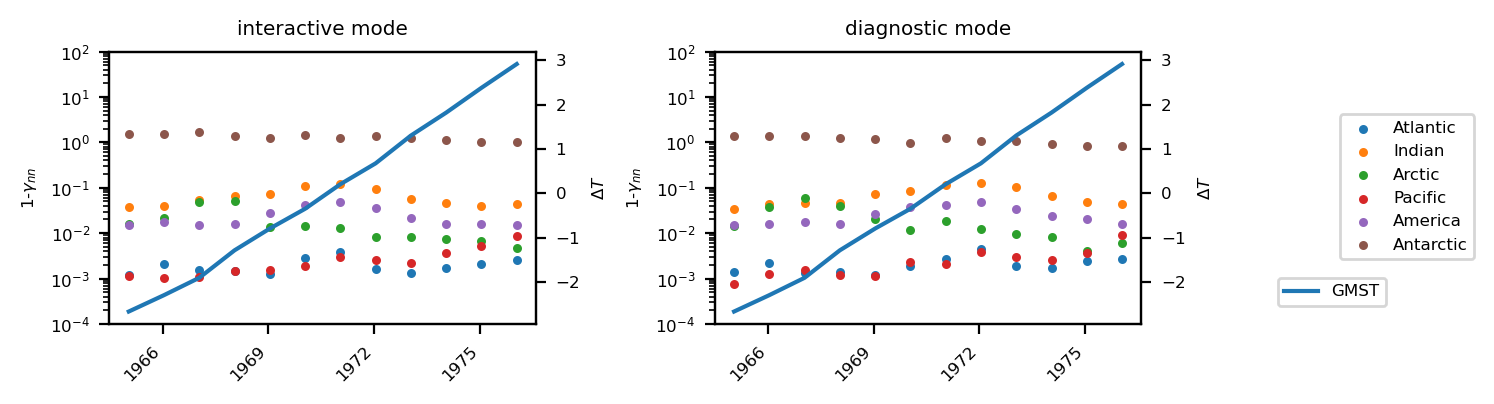

In [44]:
for iplot in range(2):
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(8,2),dpi=200)
    for ti in range(6): 
        axs[0].scatter(ytime,nn_ratio[0,ti,:].reshape(-1,12).mean(axis=1),label=tile_name[ti],s=5)
        axs[1].scatter(ytime,nn_ratio[1,ti,:].reshape(-1,12).mean(axis=1),label=tile_name[ti],s=5)

    for ax in axs:
        ax2 = ax.twinx()
        if iplot==0:
            ax2.plot(mtime,nino34, label = 'Nino3.4')
        else:
            ax2.plot(ytime,gmst_anom_y, label = 'GMST')  
        # ax2.legend() 
        ax2.set_ylabel('$\Delta T$')
        ax.set_ylabel('1-$\gamma_{nn}$')
        ax.set_yscale('log') 
        ax.set_ylim([1e-4,100])  
        # ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))
    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 0.8))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.3, 0.2))
    ax.legend(bbox_to_anchor=(1.8, 0.8)) 
    axs[0].set_title('interactive mode')
    axs[1].set_title('diagnostic mode')
    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()  